<img src="http://knoesis.org/resources/images/knoesis_depression_logo.jpg" alt="Knoesis Depression Project Logo" style="float:right;width: 250px;"/>

# Social-media Depression Detector (SDD)

#### This notebook executes the code developed to detect depression using the ssToT method introduced in our ASONAM 2017 paper titled "Semi-Supervised Approach to Monitoring Clinical Depressive Symptoms in Social Media"

This software is open-source, released under the terms of GPL-3.0 and CreativesForGood licenses.

##### Author: Hussein S. Al-Olimat (github.com/halolimat)

In [1]:
import re, json, string, datetime, random, itertools
from collections import OrderedDict, defaultdict

# You should install the following libraries
import wordsegment #https://pypi.python.org/pypi/wordsegment
from nltk import TweetTokenizer #http://www.nltk.org/api/nltk.tokenize.html
from textblob import TextBlob #https://textblob.readthedocs.io/en/dev/
from gensim import corpora #https://radimrehurek.com/gensim/
import pandas as pd #http://pandas.pydata.org/
import numpy as NP #http://www.numpy.org/
import matplotlib.pyplot as plt #https://matplotlib.org/

# You should install pSSLDA in order to be able to run this program and import these libraries
#     follow the instruction in: https://github.com/davidandrzej/pSSLDA
import FastLDA
from pSSLDA import infer

---
##### Preparing the depression lexicon to seed the LDA topics

In [2]:
# read Depression PHQ-9 Lexicon (DPL) from json file
with open("depression_lexicon.json") as f:
    seed_terms = json.load(f)

# read all seed terms into a list removing the underscore from all seeds
all_seeds_raw = [seed.replace("_"," ").encode('utf-8') for seed in list(itertools.chain.from_iterable([seed_terms[signal] for signal in seed_terms.keys()]))]

---
##### Preparing other lexicons and resources to be used in filtering and preprocessing the tweets

In [3]:
#!/usr/bin/python
# -*- coding: utf-8 -*-

# Other lexicons and resources
emojies = [":‑)", ":)", ":D", ":o)", ":]", ":3", ":c)", ":>", "=]", "8)", "=)", ":}", ":^)", ":っ)", ":‑D", "8‑D", "8D", "x‑D", "xD", "X‑D", "XD", "=‑D", "=D", "=‑3", "=3", "B^D", ":-))", ">:[", ":‑(", ":(", ":‑c", ":c", ":‑<", ":っC", ":<", ":‑[", ":[", ":{", ";(", ":-||", ":@", ">:(", ":'‑(", ":'(", ":'‑)", ":')", "D:<", "D:", "D8", "D;", "D=", "DX", "v.v", "D‑':", ">:O", ":‑O", ":O", ":‑o", ":o", "8‑0", "O_O", "o‑o", "O_o", "o_O", "o_o", "O-O", ":*", ":-*", ":^*", "(", "}{'", ")", ";‑)", ";)", "*-)", "*)", ";‑]", ";]", ";D", ";^)", ":‑,", ">:P", ":‑P", ":P", "X‑P", "x‑p", "xp", "XP", ":‑p", ":p", "=p", ":‑Þ", ":Þ", ":þ", ":‑þ", ":‑b", ":b", "d:", ">:\\", ">:/", ":‑/", ":‑.", ":/", ":\\", "=/", "=\\", ":L", "=L", ":S", ">.<", ":|", ":‑|", ":$", ":‑X", ":X", ":‑#", ":#", "O:‑)", "0:‑3", "0:3", "0:‑)", "0:)", "0;^)", ">:)", ">;)", ">:‑)", "}:‑)", "}:)", "3:‑)", "3:)", "o/\o", "^5", ">_>^", "^<_<", "|;‑)", "|‑O", ":‑J", ":‑&", ":&", "#‑)", "%‑)", "%)", ":‑###..", ":###..", "<:‑|", "<*)))‑{", "><(((*>", "><>", "\o/", "*\0/*", "@}‑;‑'‑‑‑", "@>‑‑>‑‑", "~(_8^(I)", "5:‑)", "~:‑\\", "//0‑0\\\\", "*<|:‑)", "=:o]", "7:^]", ",:‑)", "</3", "<3"]

# Tweet tokenizer from NLTK: http://www.nltk.org/_modules/nltk/tokenize/casual.html#TweetTokenizer
nltk_tok = TweetTokenizer(preserve_case=True, reduce_len=True, strip_handles=True)

printable = set(string.printable)

punctuation = list(string.punctuation)
punctuation.remove("-")
punctuation.remove('_')

long_stop_list = ["a", "a's", "abaft", "able", "aboard", "about", "above", "abst", "accordance", "according", "accordingly", "across", "act", "actually", "added", "adj", "affected", "affecting", "affects", "afore", "aforesaid", "after", "afterwards", "again", "against", "agin", "ago", "ah", "ain't", "aint", "albeit", "all", "allow", "allows", "almost", "alone", "along", "alongside", "already", "also", "although", "always", "am", "american", "amid", "amidst", "among", "amongst", "an", "and", "anent", "announce", "another", "any", "anybody", "anyhow", "anymore", "anyone", "anything", "anyway", "anyways", "anywhere", "apart", "apparently", "appear", "appreciate", "appropriate", "approximately", "are", "aren", "aren't", "arent", "arise", "around", "as", "aside", "ask", "asking", "aslant", "associated", "astride", "at", "athwart", "auth", "available", "away", "awfully", "b", "back", "bar", "barring", "be", "became", "because", "become", "becomes", "becoming", "been", "before", "beforehand", "begin", "beginning", "beginnings", "begins", "behind", "being", "believe", "below", "beneath", "beside", "besides", "best", "better", "between", "betwixt", "beyond", "biol", "both", "brief", "briefly", "but", "by", "c", "c'mon", "c's", "ca", "came", "can", "can't", "cannot", "cant", "cause", "causes", "certain", "certainly", "changes", "circa", "clearly", "close", "co", "com", "come", "comes", "concerning", "consequently", "consider", "considering", "contain", "containing", "contains", "corresponding", "cos", "could", "couldn", "couldn't", "couldnt", "couldst", "course", "currently", "d", "dare", "dared", "daren", "dares", "daring", "date", "definitely", "described", "despite", "did", "didn", "didn't", "different", "directly", "do", "does", "doesn", "doesn't", "doing", "don", "don't", "done", "dost", "doth", "down", "downwards", "due", "during", "durst", "e", "each", "early", "ed", "edu", "effect", "eg", "eight", "eighty", "either", "else", "elsewhere", "em", "end", "ending", "english", "enough", "entirely", "er", "ere", "especially", "et", "et-al", "etc", "even", "ever", "every", "everybody", "everyone", "everything", "everywhere", "ex", "exactly", "example", "except", "excepting", "f", "failing", "far", "few", "ff", "fifth", "first", "five", "fix", "followed", "following", "follows", "for", "former", "formerly", "forth", "found", "four", "from", "further", "furthermore", "g", "gave", "get", "gets", "getting", "give", "given", "gives", "giving", "go", "goes", "going", "gone", "gonna", "got", "gotta", "gotten", "greetings", "h", "had", "hadn", "hadn't", "happens", "hard", "hardly", "has", "hasn", "hasn't", "hast", "hath", "have", "haven", "haven't", "having", "he", "he'd", "he'll", "he's", "hed", "hello", "help", "hence", "her", "here", "here's", "hereafter", "hereby", "herein", "heres", "hereupon", "hers", "herself", "hes", "hi", "hid", "high", "him", "himself", "his", "hither", "home", "hopefully", "how", "how's", "howbeit", "however", "hundred", "i", "i'd", "i'll", "i'm", "i've", "id", "ie", "if", "ignored", "ill", "im", "immediate", "immediately", "importance", "important", "in", "inasmuch", "inc", "indeed", "index", "indicate", "indicated", "indicates", "information", "inner", "inside", "insofar", "instantly", "instead", "into", "invention", "inward", "is", "isn", "isn't", "it", "it'd", "it'll", "it's", "itd", "its", "itself", "j", "just", "k", "keep", "keeps", "kept", "kg", "km", "know", "known", "knows", "l", "large", "largely", "last", "lately", "later", "latter", "latterly", "least", "left", "less", "lest", "let", "let's", "lets", "like", "liked", "likely", "likewise", "line", "little", "living", "ll", "long", "look", "looking", "looks", "ltd", "m", "made", "mainly", "make", "makes", "many", "may", "maybe", "mayn", "me", "mean", "means", "meantime", "meanwhile", "merely", "mg", "mid", "midst", "might", "mightn", "million", "mine", "minus", "miss", "ml", "more", "moreover", "most", "mostly", "mr", "mrs", "much", "mug", "must", "mustn", "mustn't", "my", "myself", "n", "na", "name", "namely", "nay", "nd", "near", "nearly", "neath", "necessarily", "necessary", "need", "needed", "needing", "needn", "needs", "neither", "never", "nevertheless", "new", "next", "nigh", "nigher", "nighest", "nine", "ninety", "nisi", "no", "nobody", "non", "none", "nonetheless", "noone", "nor", "normally", "nos", "not", "noted", "nothing", "notwithstanding", "novel", "now", "nowhere", "o", "obtain", "obtained", "obviously", "of", "off", "often", "oh", "ok", "okay", "old", "omitted", "on", "once", "one", "ones", "oneself", "only", "onto", "open", "or", "ord", "other", "others", "otherwise", "ought", "oughtn", "our", "ours", "ourselves", "out", "outside", "over", "overall", "owing", "own", "p", "page", "pages", "part", "particular", "particularly", "past", "pending", "per", "perhaps", "placed", "please", "plus", "poorly", "possible", "possibly", "potentially", "pp", "predominantly", "present", "presumably", "previously", "primarily", "probably", "promptly", "proud", "provided", "provides", "providing", "public", "put", "q", "qua", "que", "quickly", "quite", "qv", "r", "ran", "rather", "rd", "re", "readily", "real", "really", "reasonably", "recent", "recently", "ref", "refs", "regarding", "regardless", "regards", "related", "relatively", "research", "respecting", "respectively", "resulted", "resulting", "results", "right", "round", "run", "s", "said", "same", "sans", "save", "saving", "saw", "say", "saying", "says", "sec", "second", "secondly", "section", "see", "seeing", "seem", "seemed", "seeming", "seems", "seen", "self", "selves", "sensible", "sent", "serious", "seriously", "seven", "several", "shall", "shalt", "shan", "shan't", "she", "she'd", "she'll", "she's", "shed", "shell", "shes", "short", "should", "shouldn", "shouldn't", "show", "showed", "shown", "showns", "shows", "significant", "significantly", "similar", "similarly", "since", "six", "slightly", "small", "so", "some", "somebody", "somehow", "someone", "somethan", "something", "sometime", "sometimes", "somewhat", "somewhere", "soon", "sorry", "special", "specifically", "specified", "specify", "specifying", "still", "stop", "strongly", "sub", "substantially", "successfully", "such", "sufficiently", "suggest", "summat", "sup", "supposing", "sure", "t", "t's", "take", "taken", "taking", "tell", "tends", "th", "than", "thank", "thanks", "thanx", "that", "that'll", "that's", "that've", "thats", "the", "thee", "their", "theirs", "them", "themselves", "then", "thence", "there", "there'll", "there's", "there've", "thereafter", "thereby", "thered", "therefore", "therein", "thereof", "therere", "theres", "thereto", "thereupon", "these", "they", "they'd", "they'll", "they're", "they've", "theyd", "theyre", "thine", "think", "third", "this", "tho", "thorough", "thoroughly", "those", "thou", "though", "thoughh", "thousand", "three", "thro", "throug", "through", "throughout", "thru", "thus", "thyself", "til", "till", "tip", "to", "today", "together", "too", "took", "touching", "toward", "towards", "tried", "tries", "true", "truly", "try", "trying", "ts", "twas", "tween", "twere", "twice", "twill", "twixt", "two", "twould", "u", "un", "under", "underneath", "unfortunately", "unless", "unlike", "unlikely", "until", "unto", "up", "upon", "ups", "us", "use", "used", "useful", "usefully", "usefulness", "uses", "using", "usually", "v", "value", "various", "ve", "versus", "very", "via", "vice", "vis-a-vis", "viz", "vol", "vols", "vs", "w", "wanna", "want", "wanting", "wants", "was", "wasn", "wasn't", "wasnt", "way", "we", "we'd", "we'll", "we're", "we've", "wed", "welcome", "well", "went", "were", "weren", "weren't", "werent", "wert", "what", "what'll", "what's", "whatever", "whats", "when", "when's", "whence", "whencesoever", "whenever", "where", "where's", "whereafter", "whereas", "whereby", "wherein", "wheres", "whereupon", "wherever", "whether", "which", "whichever", "whichsoever", "while", "whilst", "whim", "whither", "who", "who'll", "who's", "whod", "whoever", "whole", "whom", "whomever", "whore", "whos", "whose", "whoso", "whosoever", "why", "why's", "widely", "will", "willing", "wish", "with", "within", "without", "won't", "wonder", "wont", "words", "world", "would", "wouldn", "wouldn't", "wouldnt", "wouldst", "www", "x", "y", "ye", "yes", "yet", "you", "you'd", "you'll", "you're", "you've", "youd", "your", "youre", "yours", "yourself", "yourselves", "z", "zero"]
stoplist = long_stop_list + punctuation

---

##### Loading GeoText data

In [4]:
twt_df = pd.read_csv('GeoText/full_text.txt', sep='\t', header=None)
twt_df.columns = ['user_id', 'created_at', 'latlon', 'lat', 'lon', 'text']
twt_df.drop(columns=['latlon', 'lat', 'lon'], inplace=True)
twt_df.head()

,user_id,created_at,text
0,USER_79321756,2010-03-03T04:15:26,RT @USER_2ff4faca: IF SHE DO IT 1 MORE TIME......
1,USER_79321756,2010-03-03T04:55:32,@USER_77a4822d @USER_2ff4faca okay:) lol. Sayi...
2,USER_79321756,2010-03-03T05:13:34,RT @USER_5d4d777a: YOURE A FAG FOR GETTING IN ...
3,USER_79321756,2010-03-03T05:28:02,@USER_77a4822d yea ok..well answer that cheap ...
4,USER_79321756,2010-03-03T05:56:13,A sprite can disappear in her mouth - lil kim ...


In [5]:
account_tweets = twt_df[twt_df['user_id'] == twt_df.user_id.unique()[4457]].to_numpy()

In [6]:
account_tweets = account_tweets.astype(str)

In [7]:
account_tweets[:, 0] = NP.array([i for i in range(301)])

***
##### Now, we should preprocess tweets by filtering the text and recording the sentiments of each tweet

Output format: ``` [tweet_ID, created_at, raw_text, cleaned_text, sentiment]```

In [8]:
def preprocess_text(tweet):

    # this will replace seeds (as phrases) as unigrams. lack of > lack_of
    for seed in all_seeds_raw:
        if seed in tweet and " " in seed:
            tweet = tweet.replace(seed, seed.replace(" ", "_"))

    # remove retweet handler
    if tweet[:2] == "RT":
        try:
            colon_idx = tweet.index(":")
            tweet = tweet[colon_idx+2:]
        except:
            pass

    # remove url from tweet
    tweet = re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '', tweet)

    # remove non-ascii characters
    tweet = filter(lambda x: x in printable, tweet)

    # additional preprocessing
    tweet = tweet.replace("\n", " ").replace(" https","").replace("http","")

    # remove all mentions in tweet
    mentions = re.findall(r"@\w+", tweet)
    for mention in mentions:
        tweet = tweet.replace(mention, "")

    # break usernames and hashtags +++++++++++++
    for term in re.findall(r"#\w+", tweet):
        token = term[1:]

        # remove any punctuations from the hashtag and mention
        # ex: Troll_Cinema => TrollCinema
        token = token.translate(None, ''.join(string.punctuation))

        segments = wordsegment.segment(token)
        segments = ' '.join(segments)

        tweet = tweet.replace(term, segments)

    # remove all punctuations from the tweet text
    tweet = "".join([char for char in tweet if char not in punctuation])

    # remove trailing spaces
    tweet = tweet.strip()

    # remove all tokens in the tweet where the token is
    # a stop word or an emoji
    tweet = [word.lower() for word in nltk_tok.tokenize(tweet) if word.lower() not in stoplist 
                and word.lower() not in emojies and len(word) > 1]

    tweet = " ".join(tweet)

    # remove numbers
    tweet = re.sub(r'[\d-]+', 'NUM', tweet)
    # padding NUM with spaces
    tweet = tweet.replace("NUM", " NUM ")
    # remove multiple spaces in tweet text
    tweet = re.sub('\s{2,}', ' ', tweet)

    return tweet


# input: [Tweet_ID, created_at, text]
def preprocess(account_tweets):
    
    preprocessed_tweets = list()
    
    for index, tweet in enumerate(account_tweets):
        
        cleaned_text = preprocess_text(tweet[2])
        sent_score = TextBlob(tweet[2].decode('ascii', errors="ignore")).sentiment.polarity        
    
        # output: [tweet_ID, created_at, raw_text, cleaned_text, sentiment]
        preprocessed_tweets.append([tweet[0], tweet[1], tweet[2], cleaned_text, sent_score])
        
        if index % 100 == 0:
            print ".",

    return preprocessed_tweets

In [9]:
preprocessed_tweets = preprocess(account_tweets)

/home/nwrim/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:52: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal


. . . .


***
##### Now, to emulate PHQ-9 questionare, we bucket tweets based on their creation time with a sliding window of 14 days. Each bucket will then be treated as a document when we run LDA.

In [10]:
def build_sliding_buckets_on_time(account_tweets):

    size_of_bucket = 14 # days
    
    # convert list of lists to pandas dataframe
    account_tweets = pd.DataFrame(account_tweets, columns=["tweet_ID", "created_at", "raw_text", 
                                                           "cleaned_text", "sentiment"])
    
    # ensure that Created_at column is of type datetime
    account_tweets['created_at'] = pd.to_datetime(account_tweets['created_at'])

    min_date = account_tweets.created_at.min()
    max_date = account_tweets.created_at.max()
    max_date = max_date + datetime.timedelta(days=1)

    min_date = min_date.replace(hour=0, minute=0, second=0)
    max_date = max_date.replace(hour=0, minute=0, second=0)

    new_min = min_date
    new_max = min_date + datetime.timedelta(days=size_of_bucket)

    # will contain the tweets grouped in buckets
    bucketed_tweets = defaultdict(list)
    
    for index, tweet in account_tweets.iterrows():
        bucketed_tweets[0].append(tweet)

    return bucketed_tweets

In [11]:
bucketed_tweets = build_sliding_buckets_on_time(preprocessed_tweets)

***
##### Prepare the data for pSSLDA from the bucketed tweets

In [12]:
def prepare_data_for_pSSLDA(bucketed_tweets):

    texts = list()

    # each bucket is hashed on the start and end date
    for bucket in bucketed_tweets:

        all_bucket_tweets = ""

        for tweet in bucketed_tweets[bucket]:

            try:
                all_bucket_tweets += tweet.cleaned_text + " "
            except:
                # some cleaned fields are None. therefore, ignore!
                pass

        texts.append(all_bucket_tweets.strip().replace("\n", "").split(" "))

    # assign each word a unique ID
    dictionary = corpora.Dictionary(texts)

    # remove gaps in id sequence after words that were removed
    dictionary.compactify()

    voc_size = len(list(dictionary.keys()))

    # replace token ids with the token text in each doc and return similar arry of tokens and docs
    text_as_ids = list()

    # to later be the docvec
    doc_as_ids = list()

    # number of docs here is the number of buckets
    number_of_docs = len(bucketed_tweets)

    for x in range(number_of_docs):

        doc = texts[x]

        for token in doc:
            text_as_ids.append(dictionary.token2id[token])
            doc_as_ids.append(x)
 
    return text_as_ids, doc_as_ids, voc_size, dictionary.token2id, number_of_docs, bucketed_tweets

In [13]:
# docs for us will be here multiple tweets
pSSLDA_input = prepare_data_for_pSSLDA(bucketed_tweets)

***
##### Run pSSLDA allowing us to seed the LDA topics using our depression lexicon

In [14]:
# NOTE: topics and signals are used in interchangebly in this code, they both mean the same thing.

# calculated the average sentiment of a token based on its occurence in a given set of tweets
# terms sentiment is therefore taken from the tweet sentiment not targeted sentiment
def get_avg_sentiment(bucketed_tweets, token):

    term_tweets_sent_scores = get_tweets_by_term(bucketed_tweets, token)
    
    score = 0.0
    count = 0

    for sent_score in term_tweets_sent_scores:
         score += float(sent_score)
         count+=1

    return score/count


def get_tweets_by_term(bucketed_tweets, term):

    term_tweets_sent_scores = list()

    for bucket in bucketed_tweets:
        for tweet in bucketed_tweets[bucket]:
            try:
                if term in tweet.cleaned_text:
                    term_tweets_sent_scores.append(tweet.sentiment)
            except:
                # pass on empty text field
                pass

    return term_tweets_sent_scores


def get_topics_terms(tup):

    estphi = tup[0]
    W = tup[1]
    T = tup[2]
    id2token = tup[3]

    # This will contain the mappings of each term to each of our topics
    # topic1 -> termX, termY ...
    topics_dict = defaultdict(defaultdict)

    print "Reading Topics Terms: "
    
    # find the topic where each term is part of
    # W: vocabulary size
    for index in range(W):
        # projects one column of the matrix which contains the weight of the term in all of the topics
        term_weights = estphi[:,index]

        # will contain the largest weight which ->  topic it was assigned to
        largest_weight = 0

        for weight in term_weights:
            if weight > largest_weight:
                largest_weight = weight

        # this will get the index of the topic with largest weight
        term_topic = NP.argwhere(term_weights==largest_weight)[0][0]

        topics_dict[term_topic][id2token[index]] = largest_weight

        if index % 50 == 0:
            print ".",
    
    print "Done Reading Topics Terms"
    
    return topics_dict


def get_all_terms_sentiments(id2token, w, bucketed_tweets):

    seed_term_sentiment = defaultdict(float)

    unique_w = list(set(w))

    for wi in unique_w:
        token = id2token[wi]

        if token in seed_terms['signal_1']:
            seed_term_sentiment[token] = get_avg_sentiment(bucketed_tweets, token)

        elif token in seed_terms['signal_2']:
            seed_term_sentiment[token] = get_avg_sentiment(bucketed_tweets, token)

        elif token in seed_terms['signal_3']:
            seed_term_sentiment[token] = get_avg_sentiment(bucketed_tweets, token)

        elif token in seed_terms['signal_4']:
            seed_term_sentiment[token] = get_avg_sentiment(bucketed_tweets, token)

        elif token in seed_terms['signal_5']:
            seed_term_sentiment[token] = get_avg_sentiment(bucketed_tweets, token)

        elif token in seed_terms['signal_6']:
            seed_term_sentiment[token] = get_avg_sentiment(bucketed_tweets, token)

        elif token in seed_terms['signal_7']:
            seed_term_sentiment[token] = get_avg_sentiment(bucketed_tweets, token)

        elif token in seed_terms['signal_8']:
            seed_term_sentiment[token] = get_avg_sentiment(bucketed_tweets, token)

        elif token in seed_terms['signal_9']:
            seed_term_sentiment[token] = get_avg_sentiment(bucketed_tweets, token)

        elif token in seed_terms['signal_10']:
            seed_term_sentiment[token] = get_avg_sentiment(bucketed_tweets, token)

    return seed_term_sentiment

# This is a modified version of the code in https://github.com/davidandrzej/pSSLDA/blob/master/example/example.py
def run_pSSLDA(pSSLDA_input, parameters):
    
    print "Running ssToT"

    token2id = pSSLDA_input[3]

    # number of topics
    T = parameters["topics_count"]

    (wordvec, docvec, zvec) = ([], [], [])

    # vector of words per tweet
    wordvec = pSSLDA_input[0]
    docvec = pSSLDA_input[1]

    # W = vocabulary size
    W = pSSLDA_input[2]

    (w, d) = (NP.array(wordvec, dtype = NP.int),
              NP.array(docvec, dtype = NP.int))

    # Create parameters
    alpha = NP.ones((1,T)) * 1
    beta = NP.ones((T,W)) * 0.01

    # How many parallel samplers do we wish to use?
    P = 1

    # Random number seed
    randseed =  random.randint(999,999999)# 194582

    # Number of samples to take
    numsamp = 500

    # Do parallel inference
    finalz = infer(w, d, alpha, beta, numsamp, randseed, P)

    # number of documents = tweets
    D = pSSLDA_input[4]

    # Estimate phi and theta
    (nw, nd) = FastLDA.countMatrices(w, W, d, D, finalz, T)
    (estphi,esttheta) = FastLDA.estPhiTheta(nw, nd, alpha, beta)

    # ======================================================================

    # swap keys with values in the token2id => id2token
    id2token = dict((v,k) for k,v in token2id.iteritems())

    seed_term_sentiment = get_all_terms_sentiments(id2token, w, pSSLDA_input[5])

    # ----------------------------------------------------------------------
    
    # Now, we add z-labels to *force* words into separate topics
    
    labelweight = 5.0

    label0 = NP.zeros((T,), dtype=NP.float)
    label0[0] = labelweight

    label1 = NP.zeros((T,), dtype=NP.float)
    label1[1] = labelweight

    label2 = NP.zeros((T,), dtype=NP.float)
    label2[2] = labelweight

    label3 = NP.zeros((T,), dtype=NP.float)
    label3[3] = labelweight

    label4 = NP.zeros((T,), dtype=NP.float)
    label4[4] = labelweight

    label5 = NP.zeros((T,), dtype=NP.float)
    label5[5] = labelweight

    label6 = NP.zeros((T,), dtype=NP.float)
    label6[6] = labelweight

    label7 = NP.zeros((T,), dtype=NP.float)
    label7[7] = labelweight

    label8 = NP.zeros((T,), dtype=NP.float)
    label8[8] = labelweight

    label9 = NP.zeros((T,), dtype=NP.float)
    label9[9] = labelweight

    label10 = NP.zeros((T,), dtype=NP.float)
    label10[10] = labelweight

    label11 = NP.zeros((T,), dtype=NP.float)
    label11[11] = labelweight

    # signals ids
    corpus_signals = [0,1,2,3,4,5,6,7,8,9]
   
    seed_terms_per_signal = defaultdict(lambda: defaultdict(int))

    zlabels = []
    for wi in w:

        token = id2token[wi]

        # if the word appears in topic 0
        if token in seed_terms['signal_1'] and  seed_term_sentiment[token] <= 0:

            zlabels.append(label0)

            seed_terms_per_signal['signal_1'][token]+=1

            if 0 in corpus_signals:
                corpus_signals.remove(0)


        elif token in seed_terms['signal_2'] and  seed_term_sentiment[token] <= 0:

            zlabels.append(label1)

            seed_terms_per_signal['signal_2'][token]+=1

            if 1 in corpus_signals:
                corpus_signals.remove(1)


        elif token in seed_terms['signal_3'] and seed_term_sentiment[token] <= 0:

            zlabels.append(label2)

            seed_terms_per_signal['signal_3'][token]+=1

            if 2 in corpus_signals:
                corpus_signals.remove(2)


        elif token in seed_terms['signal_4'] and seed_term_sentiment[token] <= 0:

            zlabels.append(label3)
            seed_terms_per_signal['signal_4'][token]+=1

            if 3 in corpus_signals:
                corpus_signals.remove(3)


        elif token in seed_terms['signal_5'] and seed_term_sentiment[token] <= 0:

            zlabels.append(label4)

            seed_terms_per_signal['signal_5'][token]+=1

            if 4 in corpus_signals:
                corpus_signals.remove(4)

        elif token in seed_terms['signal_6'] and  seed_term_sentiment[token] <= 0:

            zlabels.append(label5)

            seed_terms_per_signal['signal_6'][token]+=1

            if 5 in corpus_signals:
                corpus_signals.remove(5)

        elif token in seed_terms['signal_7'] and  seed_term_sentiment[token] <= 0:

            zlabels.append(label6)

            seed_terms_per_signal['signal_7'][token]+=1

            if 6 in corpus_signals:
                corpus_signals.remove(6)

        elif token in seed_terms['signal_8'] and  seed_term_sentiment[token] <= 0:

            zlabels.append(label7)

            seed_terms_per_signal['signal_8'][token]+=1

            if 7 in corpus_signals:
                corpus_signals.remove(7)

        elif token in seed_terms['signal_9'] and  seed_term_sentiment[token] <= 0:

            zlabels.append(label8)

            seed_terms_per_signal['signal_9'][token]+=1

            if 8 in corpus_signals:
                corpus_signals.remove(8)

        elif token in seed_terms['signal_10'] and  seed_term_sentiment[token] <= 0:

            zlabels.append(label9)

            seed_terms_per_signal['signal_10'][token]+=1

            if 9 in corpus_signals:
                corpus_signals.remove(9)

        else:
            zlabels.append(None)


    # --------------------------------------------------------------------

    # Now inference will find topics with 0 and 1 in separate topics
    finalz = infer(w, d, alpha, beta, numsamp, randseed, P, zlabels = zlabels)

    # Re-estimate phi and theta
    (nw, nd) = FastLDA.countMatrices(w, W, d, D, finalz, T)
    (estphi,esttheta) = FastLDA.estPhiTheta(nw, nd, alpha, beta)

    # --------------------------------------------------------------------
    
    # Find the sentiment of each topic cluster based on the tweets where each seed term appered in

    tup = (estphi, W, T, id2token)
    topics_terms = get_topics_terms(tup)
    
    # --------------------------------------------------------------------
    
    # TODO: refactor this subroutine to make it faster, use inverted index!
    
    sent_scores = defaultdict(list)

    print "Calculating topics sentiments: "
    
    counter = 0
    for topic in topics_terms:

        topic_sent_scores = list()

        for term in topics_terms[topic]:
            term_tweets_sent_scores = get_tweets_by_term(pSSLDA_input[5], term)

            for sent_score in term_tweets_sent_scores:
                 topic_sent_scores.append(float(sent_score))

        avg = sum(topic_sent_scores) / float(len(topic_sent_scores))

        sent_scores[topic] = (topic_sent_scores, avg)
        
        counter+=1
        print ".",

    # --------------------------------------------------------------------
        
    # post processing of topics. If the bucket has less than 30 tweets then
    # discard the probabilities of that bucket

    len_buckets = []
    for bucket in pSSLDA_input[5]:
        len_b = len(pSSLDA_input[5][bucket])
        len_buckets.append(len_b)

   
    # threshold #1: if number of tweets in that bucket is less than x, then discard that bucket.
    min_number_of_tweets_per_bucket = parameters["min_tweets_per_bucket"]
    
    for x in range(len(len_buckets)):
        if len_buckets[x] <= min_number_of_tweets_per_bucket:
            esttheta[x, :] = 0

    # this will replace zero to the probabilities of the topic by ID if no seed terms were found in the corpus
    for topic_id in corpus_signals:
        esttheta[:, topic_id] = 0

    all_topics_seeds = list()
    for signal in seed_terms_per_signal:
        all_topics_seeds += seed_terms_per_signal[signal]

    # topics to keep
    seeds_in_top_k = defaultdict(int)

    # number of seed terms that should be in the top topic terms
    seeds_threshold = parameters["seeds_threshold"]
    # The number of terms in the topic that we will look into to search for seed terms
    top_topic_terms = parameters["top_topic_terms"]

    for topic in topics_terms:
        for x in range(len(topics_terms[topic])):
            term = list(topics_terms[topic])[x]
            if x < top_topic_terms:
                if term in all_topics_seeds:
                    seeds_in_top_k[topic] += 1

    # this will replace zero to the probabilities of the topic by ID if no seed terms were found in the corpus
    for x in range(len(esttheta[0])):
        if x in seeds_in_top_k.keys():
            if seeds_in_top_k[x] < seeds_threshold:
                esttheta[:, x] = 0
        else:
            esttheta[:, x] = 0


    return (estphi, W, T, id2token), esttheta, topics_terms, seed_terms_per_signal

In [15]:
''' 
    topics_count: number of topics/signals to construct using pSSLDA
    min_tweets_per_bucket: minimum number of tweets per bucket to constructs and accept a topic from it
    seeds_threshold: number of seed terms in the top topic terms
    top_topic_terms: the number of terms to consider when searching for seed terms
'''
parameters = {"topics_count": 15, "min_tweets_per_bucket": 20, "seeds_threshold": 2, "top_topic_terms": 25}

# pSSLDA_input: 0> estphi_tup | 1> esttheta | 2> topics_terms | 3> seed_terms_per_signal
pSSLDA_output = run_pSSLDA(pSSLDA_input, parameters)

Running ssToT
Online z initialization
Assigning documents to partitions
Getting indices associated with each partition
Create re-numbered doc vectors for each partition
Initializing count matrices
Launching Sampler processes
Computing global nw count matrix
Sample 0 of 500
Sample 1 of 500
Sample 2 of 500
Sample 3 of 500
Sample 4 of 500
Sample 5 of 500
Sample 6 of 500
Sample 7 of 500
Sample 8 of 500
Sample 9 of 500
Sample 10 of 500
Sample 11 of 500
Sample 12 of 500
Sample 13 of 500
Sample 14 of 500
Sample 15 of 500
Sample 16 of 500
Sample 17 of 500
Sample 18 of 500
Sample 19 of 500
Sample 20 of 500
Sample 21 of 500
Sample 22 of 500
Sample 23 of 500
Sample 24 of 500
Sample 25 of 500
Sample 26 of 500
Sample 27 of 500
Sample 28 of 500
Sample 29 of 500
Sample 30 of 500
Sample 31 of 500
Sample 32 of 500
Sample 33 of 500
Sample 34 of 500
Sample 35 of 500
Sample 36 of 500
Sample 37 of 500
Sample 38 of 500
Sample 39 of 500
Sample 40 of 500
Sample 41 of 500
Sample 42 of 500
Sample 43 of 500
Samp

Computing global nw count matrix
Sample 0 of 500
Sample 1 of 500
Sample 2 of 500
Sample 3 of 500
Sample 4 of 500
Sample 5 of 500
Sample 6 of 500
Sample 7 of 500
Sample 8 of 500
Sample 9 of 500
Sample 10 of 500
Sample 11 of 500
Sample 12 of 500
Sample 13 of 500
Sample 14 of 500
Sample 15 of 500
Sample 16 of 500
Sample 17 of 500
Sample 18 of 500
Sample 19 of 500
Sample 20 of 500
Sample 21 of 500
Sample 22 of 500
Sample 23 of 500
Sample 24 of 500
Sample 25 of 500
Sample 26 of 500
Sample 27 of 500
Sample 28 of 500
Sample 29 of 500
Sample 30 of 500
Sample 31 of 500
Sample 32 of 500
Sample 33 of 500
Sample 34 of 500
Sample 35 of 500
Sample 36 of 500
Sample 37 of 500
Sample 38 of 500
Sample 39 of 500
Sample 40 of 500
Sample 41 of 500
Sample 42 of 500
Sample 43 of 500
Sample 44 of 500
Sample 45 of 500
Sample 46 of 500
Sample 47 of 500
Sample 48 of 500
Sample 49 of 500
Sample 50 of 500
Sample 51 of 500
Sample 52 of 500
Sample 53 of 500
Sample 54 of 500
Sample 55 of 500
Sample 56 of 500
Sample 5

Sample 473 of 500
Sample 474 of 500
Sample 475 of 500
Sample 476 of 500
Sample 477 of 500
Sample 478 of 500
Sample 479 of 500
Sample 480 of 500
Sample 481 of 500
Sample 482 of 500
Sample 483 of 500
Sample 484 of 500
Sample 485 of 500
Sample 486 of 500
Sample 487 of 500
Sample 488 of 500
Sample 489 of 500
Sample 490 of 500
Sample 491 of 500
Sample 492 of 500
Sample 493 of 500
Sample 494 of 500
Sample 495 of 500
Sample 496 of 500
Sample 497 of 500
Sample 498 of 500
Sample 499 of 500
Reading Topics Terms: 
. . . . . . . . . . . . . . . Done Reading Topics Terms
Calculating topics sentiments: 
. . . . . . . . . . . . . . .


In [16]:
def detect_depression(pSSLDA_output):
    
    try:

        esttheta = pSSLDA_output[1]

        print
        print "<<<<<<< Topics Probabilties Over Time >>>>>>>"
        print 
                
        headers = ["Time Period", "Signal-1", "Signal-2", "Signal-3", "Signal-4", "Signal-5",
                                  "Signal-6", "Signal-7", "Signal-8", "Signal-9", "Signal-10"]
        
        rows = list()
        
        counter = 0
        for key in bucketed_tweets.keys():
            
            # list of series to dataframe
            df = pd.DataFrame(bucketed_tweets[key])
                        
            bucket_date = str(df.created_at.min().strftime("%d/%m/%Y")) + " To " + \
                          str(df.created_at.max().strftime("%d/%m/%Y"))
            
            row = [bucket_date] + [esttheta[counter][x] for x in range(len(esttheta[counter])) if x < 10]
            
            rows.append(row)

            # increment counter to get element from the result matrix
            counter+=1

        topics_probabilities = pd.DataFrame(rows, columns=headers)
        
        print topics_probabilities
        
        topics_probabilities.plot(kind='line')
        plt.show()
                
        #--------------------------------------------------------------------------------------------

        print
        print "<<<<<<< Topics Terms >>>>>>>"
        print 

        
        headers = ["Topic Number", "Topic Terms"]
        rows = list()
        
        for topic in pSSLDA_output[2]:

            topic_nbr = topic+1
            
            rows.append([topic_nbr, ", ".join(pSSLDA_output[2][topic])])

        topics_terms = pd.DataFrame(rows, columns=headers)
                    
        print topics_terms
        
        #--------------------------------------------------------------------------------------------

        print
        print "<<<<<<< Seeded Terms Per Topic >>>>>>>"
        print

        headers = ["Topic Number", "Seed Terms:Count"]
        rows = list()
        
        # pSSLDA_output[3] = seed_terms_per_signal
        for topic in pSSLDA_output[3]:
            
            seedTerms = [str(seedTerm)+":"+str(pSSLDA_output[3][topic][seedTerm]) 
                                         for seedTerm in pSSLDA_output[3][topic]]
            
            rows.append([topic, ", ".join(seedTerms)])
        
        topics_seeds = pd.DataFrame(rows, columns=headers)
                    
        print topics_seeds

    except AssertionError:
        print "ERROR: number of tweets is insufficents for depression detection!"
    except Exception as e:
        print "ERROR >>> ", e
        raise


<<<<<<< Topics Probabilties Over Time >>>>>>>

                Time Period  Signal-1  Signal-2  Signal-3  Signal-4  Signal-5  \
0  02/03/2010 To 07/03/2010       0.0       0.0       0.0       0.0       0.0   

   Signal-6  Signal-7  Signal-8  Signal-9  Signal-10  
0       0.0       0.0       0.0  0.060811        0.0  


/home/nwrim/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_base.py:3152: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0.0, right=0.0
  'left=%s, right=%s') % (left, right))


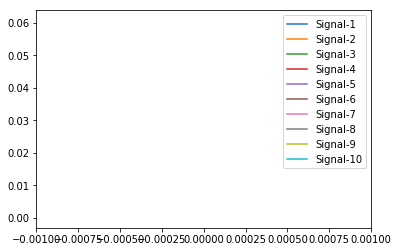


<<<<<<< Topics Terms >>>>>>>

    Topic Number                                        Topic Terms
0              1  ltlt, goood, eagle, imbored, lips, udeaded, ma...
1              2  iwanna, telln, stufff, icatch, matta, tryna, h...
2              3  tat, letters, tch, edd, chass, twitter, deynad...
3              4  ppl, ladies, fcking, ali, lmaoo, uhuhhh, feeli...
4              5  , amber, bettter, liar, gtteam, win, von, youn...
5              6  ihit, radios, gunna, circus, gz, bring, bdays,...
6              7  igot, standin, love, liee, site, grosss, nicol...
7              8  phoney, twitcon, feel, poppin, twin, describe,...
8              9  dont, chinese, whiteplains, money, honeys, kil...
9             10  mlkshake, apple, people, ee, laughs, woods, vi...
10            11  figure, unfollowed, sigh, werk, ugona, uget, g...
11            12  baconyup, icnt, gt, ididdd, bert, upset, gonn,...
12            13  rag, tha, qot, drunk, sweet, meniggas, accept,...
13            14 

In [17]:
detect_depression(pSSLDA_output)